In [7]:
import pandas as pd
import numpy as np

# Simulate node names
num_lnc = 100
num_gene = 100
lnc_nodes = [f'lncRNA{i}' for i in range(num_lnc)]
gene_nodes = [f'gene{i}' for i in range(num_gene)]
all_nodes = lnc_nodes + gene_nodes

# Generate 1000 edges connecting random nodes
num_edges = 1000
np.random.seed(42)
edge_sources = np.random.choice(all_nodes, num_edges)
edge_targets = np.random.choice(all_nodes, num_edges)

edge_df = pd.DataFrame({'source': edge_sources, 'target': edge_targets})

# Assign a random label (0/1) to each node
labels = np.random.choice([0, 1], size=len(all_nodes))
label_df = pd.DataFrame({'node': all_nodes, 'label': labels})

print(edge_df)

       source    target
0       gene2    gene67
1      gene79    gene12
2    lncRNA92  lncRNA82
3    lncRNA14  lncRNA41
4       gene6    gene68
..        ...       ...
995    gene10    gene57
996    gene10    gene60
997  lncRNA33  lncRNA76
998    gene10    gene15
999   lncRNA7    gene53

[1000 rows x 2 columns]


In [8]:
import torch
from torch_geometric.data import Data

# Build a node-to-index mapping
node2idx = {name: i for i, name in enumerate(all_nodes)}
num_nodes = len(all_nodes)

# edge_index construction
edge_index = torch.tensor([
    edge_df['source'].map(node2idx).values,
    edge_df['target'].map(node2idx).values
], dtype=torch.long)

# Construct label tensor y, same order as all_nodes
y_map = dict(zip(label_df['node'], label_df['label']))
y = torch.tensor([y_map[node] for node in all_nodes], dtype=torch.long)

# Split train/test mask (80% train, 20% test)
idx = np.arange(num_nodes)
np.random.shuffle(idx)
train_size = int(0.8 * num_nodes)
train_idx = idx[:train_size]
test_idx = idx[train_size:]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

# Create PyG Data object
data = Data(
    edge_index=edge_index,
    y=y,
    train_mask=train_mask,
    test_mask=test_mask
)


In [3]:
print(data)

Data(edge_index=[2, 1000], y=[200], train_mask=[200], test_mask=[200])


In [9]:
from torch_geometric.nn import Node2Vec
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(
    data.edge_index, embedding_dim=64,
    walk_length=10, context_size=5, walks_per_node=5,
    num_negative_samples=1, p=1, q=1, sparse=True
).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=0)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

from tqdm import tqdm

def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

for epoch in range(1, 31):  # Run 30 epochs for demonstration
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 62.26it/s]


Epoch: 01, Loss: 6.8602, Acc: 0.4750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 67.98it/s]


Epoch: 02, Loss: 6.5446, Acc: 0.4750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 85.43it/s]


Epoch: 03, Loss: 6.2988, Acc: 0.4750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 81.86it/s]


Epoch: 04, Loss: 6.0820, Acc: 0.4750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 85.60it/s]


Epoch: 05, Loss: 5.8270, Acc: 0.4750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 73.88it/s]


Epoch: 06, Loss: 5.6320, Acc: 0.4750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 60.28it/s]


Epoch: 07, Loss: 5.4360, Acc: 0.4750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 77.88it/s]


Epoch: 08, Loss: 5.1923, Acc: 0.4750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 78.09it/s]


Epoch: 09, Loss: 5.0565, Acc: 0.4750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 62.78it/s]


Epoch: 10, Loss: 4.8713, Acc: 0.4750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 73.47it/s]


Epoch: 11, Loss: 4.7606, Acc: 0.4500


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 82.12it/s]


Epoch: 12, Loss: 4.6552, Acc: 0.4500


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 66.79it/s]


Epoch: 13, Loss: 4.5145, Acc: 0.4500


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 83.28it/s]


Epoch: 14, Loss: 4.3491, Acc: 0.4500


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 81.77it/s]


Epoch: 15, Loss: 4.2278, Acc: 0.4500


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 80.80it/s]


Epoch: 16, Loss: 4.1338, Acc: 0.4500


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 92.76it/s]


Epoch: 17, Loss: 4.0076, Acc: 0.4750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 89.44it/s]


Epoch: 18, Loss: 3.9045, Acc: 0.4750


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 87.23it/s]

Epoch: 19, Loss: 3.7746, Acc: 0.4750



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 82.45it/s]

Epoch: 20, Loss: 3.7438, Acc: 0.4750



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 87.68it/s]


Epoch: 21, Loss: 3.5938, Acc: 0.4500


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 85.38it/s]

Epoch: 22, Loss: 3.5537, Acc: 0.4500



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 85.79it/s]


Epoch: 23, Loss: 3.4352, Acc: 0.4500


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 91.75it/s]


Epoch: 24, Loss: 3.4172, Acc: 0.4500


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 86.70it/s]

Epoch: 25, Loss: 3.3078, Acc: 0.4500



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 88.59it/s]

Epoch: 26, Loss: 3.2194, Acc: 0.4500



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 81.70it/s]


Epoch: 27, Loss: 3.2356, Acc: 0.4500


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 94.71it/s]


Epoch: 28, Loss: 3.0890, Acc: 0.4500


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 84.54it/s]


Epoch: 29, Loss: 3.0293, Acc: 0.4500


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 86.85it/s]


Epoch: 30, Loss: 2.9332, Acc: 0.4500


D:\work\conda\ana\envs\RecGCN\lib\site-packages\torch_geometric\data\storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'test_mask', 'edge_index', 'y', 'train_mask'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


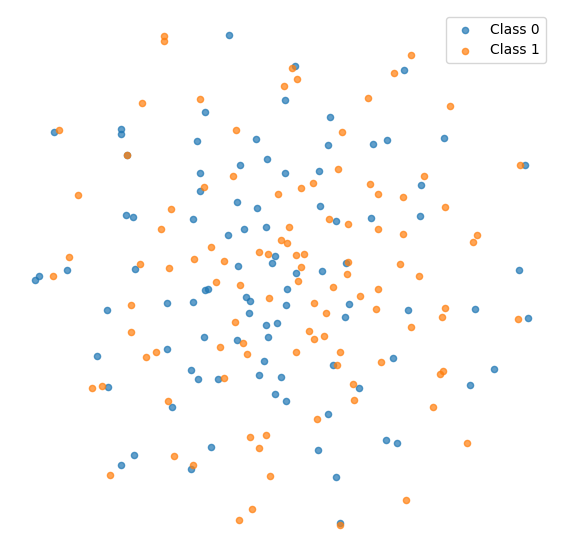

In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

@torch.no_grad()
def plot_points():
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y_np = data.y.cpu().numpy()
    plt.figure(figsize=(7,7))
    for label in np.unique(y_np):
        plt.scatter(z[y_np==label,0], z[y_np==label,1], s=20, label=f'Class {label}', alpha=0.7)
    plt.legend()
    plt.axis('off')
    plt.show()

plot_points()
